## Read datasets

In [1]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import xgboost
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.model_selection import StratifiedKFold,train_test_split,RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle
# read dataset
df = pd.read_csv('../data/Loan_Default.csv')
df.drop(columns=['ID','year','Interest_rate_spread','Upfront_charges','rate_of_interest'],inplace=True)
df = df.sample(20000,random_state=42)
X = df.drop(columns='Status')
y = df['Status']

## Preprocessing strategy

In [2]:
binary_cat_ftrs = ['Credit_Worthiness', 'open_credit', 'business_or_commercial', 'interest_only', 'lump_sum_payment', 'construction_type', 'Secured_by', 'co-applicant_credit_type', 'Security_Type']
ordinal_ftrs = ['total_units','age'] 
ordinal_cats = [['1U', '2U', '3U', '4U','missing'], 
                ['<25','25-34','35-44','45-54','55-64','65-74','>74','missing']]
onehot_ftrs = ['loan_limit','approv_in_adv','Gender','loan_type','loan_purpose','Neg_ammortization','occupancy_type','credit_type','submission_of_application','Region']

categorical_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

ordinal_transformer = Pipeline(steps=[
    ('ord_imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', OrdinalEncoder(categories=ordinal_cats))
])

labelEncoding_transformer = OrdinalEncoder()

transformer = ColumnTransformer(
transformers=[
    ('cat', categorical_transformer, onehot_ftrs),
    ('ord', ordinal_transformer, ordinal_ftrs),
    ('bi_cat',labelEncoding_transformer,binary_cat_ftrs)
], remainder='passthrough')

final_standard = StandardScaler()

preprocessor = Pipeline(steps=[
    ('transformer', transformer),
    ('final_standard', final_standard)
])

## Build the model pipeline

In [3]:
def MLpipe_KFold_XGB(X, y, preprocessor, param_grid):
    test_scores = []
    best_models = []
    test_sets = []
    nr_states = 5
   
    for i in range(nr_states):
        X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.2,random_state=i)
        kf = StratifiedKFold(n_splits=4,shuffle=True,random_state=i)
        clf = xgboost.XGBClassifier(eval_metric='logloss',random_state=i) 
        pipe = make_pipeline(preprocessor, clf)
        grid =RandomizedSearchCV(pipe, param_grid, scoring='accuracy', cv=kf, return_train_score=True, n_jobs=-1, verbose=True,random_state=i)
        
        grid.fit(X_other,y_other)
        print(f"Best Parameters: {grid.best_params_}")
        best_model = grid.best_estimator_
        best_models.append(best_model)
        # calculate and save the test score
        y_test_pred = best_model.predict(X_test)
        test_scores.append(accuracy_score(y_test,y_test_pred))
        test_sets.append([X_test, y_test])
    return test_sets, test_scores, best_models

In [4]:
param_grid = {
    'xgbclassifier__max_depth': [3, 10, 50, 100],
    'xgbclassifier__learning_rate': [0.01, 0.1, 1],
    'xgbclassifier__n_estimators': [100, 200, 500]
    }

test_sets, test_scores, best_models= MLpipe_KFold_XGB(X, y, preprocessor, param_grid)



Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best Parameters: {'xgbclassifier__n_estimators': 200, 'xgbclassifier__max_depth': 10, 'xgbclassifier__learning_rate': 0.1}
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best Parameters: {'xgbclassifier__n_estimators': 100, 'xgbclassifier__max_depth': 100, 'xgbclassifier__learning_rate': 0.1}
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best Parameters: {'xgbclassifier__n_estimators': 500, 'xgbclassifier__max_depth': 3, 'xgbclassifier__learning_rate': 0.1}
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best Parameters: {'xgbclassifier__n_estimators': 200, 'xgbclassifier__max_depth': 3, 'xgbclassifier__learning_rate': 0.1}
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best Parameters: {'xgbclassifier__n_estimators': 100, 'xgbclassifier__max_depth': 10, 'xgbclassifier__learning_rate': 0.1}


In [5]:
most_frequent_class = y.mode()[0]
value_counts = y.value_counts(normalize=True)
baseline_accuracy = value_counts[most_frequent_class]
print(f"Baseline of accuracy score: {baseline_accuracy:.4}")
print('*' * 50)
print(f'mean of the test scores: {np.mean(test_scores)}')
print(f'the standard deviation of the test scores: {np.std(test_scores)}')

Baseline of accuracy score: 0.7606
**************************************************
mean of the test scores: 0.8910499999999999
the standard deviation of the test scores: 0.0055213223053902595


In [ ]:
# save the models
file = open('../results/XGB_grid.save', 'wb')
pickle.dump((test_sets, best_models),file)
file.close()

## Load and interpret the model

In [ ]:
file = open('../results/XGB_grid.save', 'rb')
test_sets, best_models = pickle.load(file)
file.close()

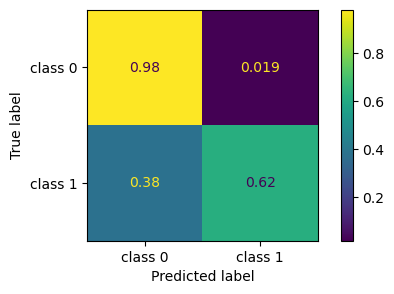

In [8]:
idx = np.argmax(test_scores)
test_set = test_sets[idx]
model = best_models[idx]
X_test,y_test = test_set
cm = confusion_matrix(y_test,model.predict(X_test))
disp = ConfusionMatrixDisplay((cm.T/np.sum(cm.T,axis=0)).T,display_labels=['class 0', 'class 1'])
fig, ax = plt.subplots(figsize=(6,3))
disp.plot(ax=ax)
plt.show()

In [9]:
f1_score(y_test,model.predict(X_test))

0.7383606557377049

#### PermutationPermutation feature importance

In [10]:
ftr_names = X_test.columns
nr_runs = 10
scores = np.zeros([len(ftr_names),nr_runs])
np.random.seed(42)
test_score = model.score(X_test,y_test)
print('test score = ',test_score)
print('test baseline = ',np.sum(y_test == 0)/len(y_test))
# loop through the features
for i in range(len(ftr_names)):
    print('shuffling '+str(ftr_names[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
        acc_scores.append(model.score(X_test_shuffled,y_test))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

test score =  0.90025
test baseline =  0.77425
shuffling loan_limit
   shuffled test score: 0.898 +/- 0.001
shuffling Gender
   shuffled test score: 0.9 +/- 0.001
shuffling approv_in_adv
   shuffled test score: 0.899 +/- 0.001
shuffling loan_type
   shuffled test score: 0.877 +/- 0.001
shuffling loan_purpose
   shuffled test score: 0.873 +/- 0.003
shuffling Credit_Worthiness
   shuffled test score: 0.897 +/- 0.001
shuffling open_credit
   shuffled test score: 0.9 +/- 0.0
shuffling business_or_commercial
   shuffled test score: 0.9 +/- 0.0
shuffling loan_amount
   shuffled test score: 0.872 +/- 0.003
shuffling term
   shuffled test score: 0.9 +/- 0.0
shuffling Neg_ammortization
   shuffled test score: 0.889 +/- 0.001
shuffling interest_only
   shuffled test score: 0.9 +/- 0.0
shuffling lump_sum_payment
   shuffled test score: 0.891 +/- 0.001
shuffling property_value
   shuffled test score: 0.836 +/- 0.004
shuffling construction_type
   shuffled test score: 0.9 +/- 0.0
shuffling occupanc

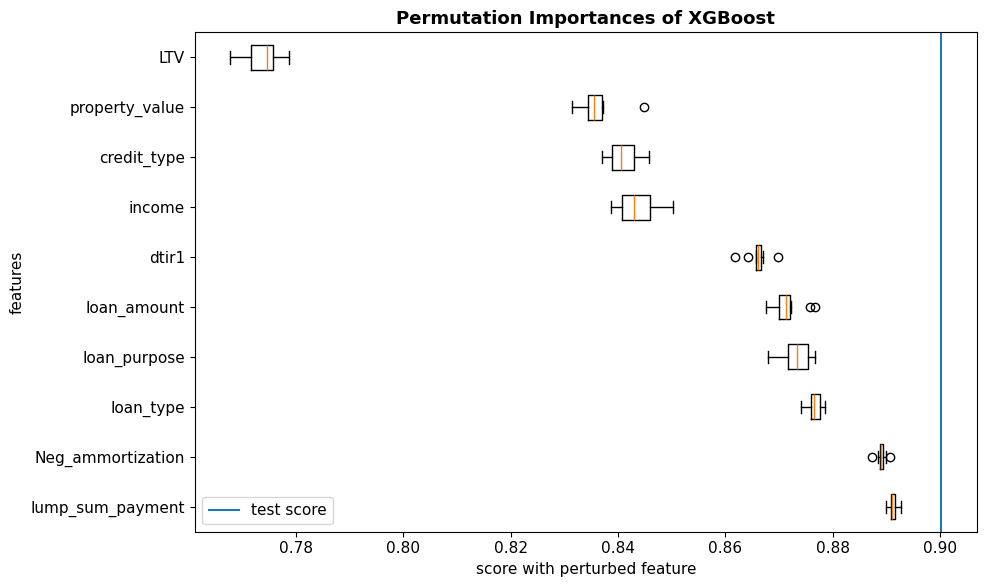

In [11]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[:10][::-1]
plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(10,6))
plt.boxplot(scores[sorted_indcs].T,tick_labels=ftr_names[sorted_indcs],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances of XGBoost", fontsize=13, fontweight='bold')
plt.xlabel('score with perturbed feature')
plt.ylabel('features')
plt.legend()
plt.tight_layout()
plt.savefig('Permutation Importances of XGBoost.png', bbox_inches='tight', dpi=500)
plt.show()

#### global feature importance in XGBoost

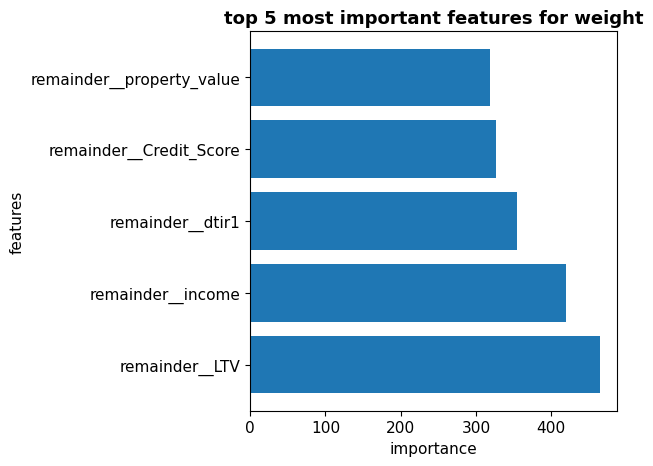

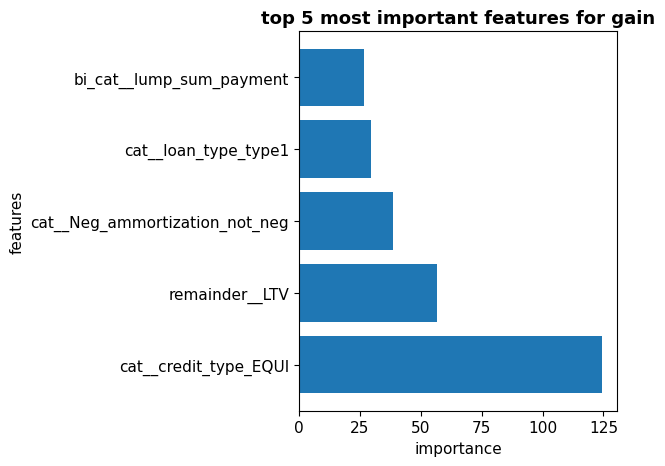

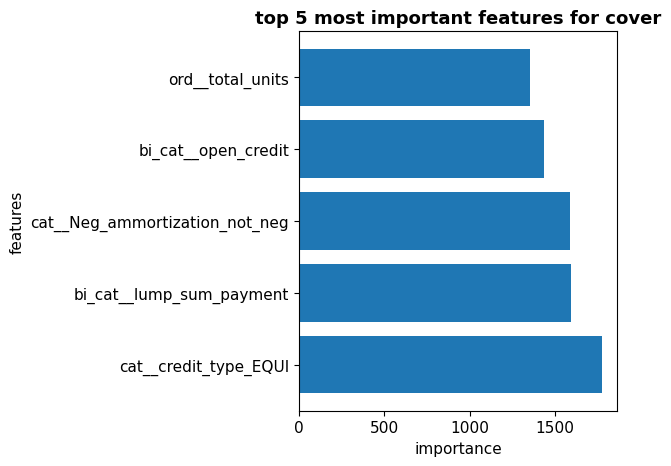

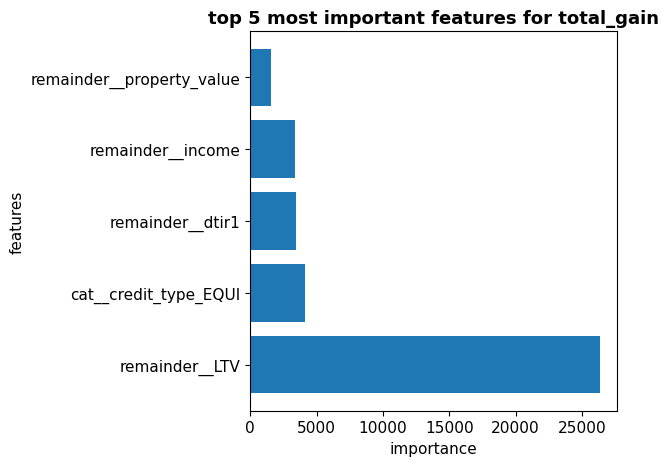

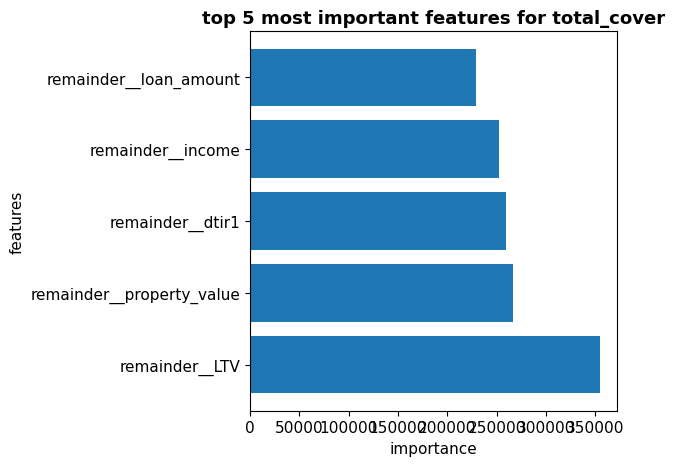

In [12]:
metrics = ["weight", "gain", "cover", "total_gain", "total_cover"]
feature_names = model[:-1].get_feature_names_out()

for metric in metrics:
    total_importance = model[-1].get_booster().get_score(importance_type=f'{metric}')
    ordered_total_importance = list(sorted(total_importance.items(),key = lambda x:x[1] ,reverse=True))
    top_10_features, top_10_importance = zip(*ordered_total_importance[:5])
    top_10_indices = [int(f[1:]) for f in top_10_features]
    top_10_feature_names = [feature_names[i] for i in top_10_indices]
    plt.barh(range(5),top_10_importance)
    plt.yticks(ticks=range(5), labels=top_10_feature_names)
    plt.ylabel('features')
    plt.xlabel('importance')
    plt.title(f'top 5 most important features for {metric}',fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'global feature importances of XGBoost by {metric}.png', bbox_inches='tight', dpi=500)
    plt.show()

#### local importance in shap

In [13]:
import shap
shap.initjs() 
explainer = shap.TreeExplainer(model[-1])
X_test_transformed =model[:-1].transform(X_test)
print(np.shape(X_test_transformed))
shap_values = explainer.shap_values(X_test_transformed)
print(np.shape(shap_values))

(4000, 53)
(4000, 53)


In [14]:
index = 42
print(explainer.expected_value) 


force_plot = shap.force_plot(explainer.expected_value, shap_values[index], features = X_test_transformed[index],feature_names = feature_names,link = 'logit',show=False)
shap.save_html("shap_force_plot1.html", force_plot)


-1.1795937


In [15]:
index = 121

force_plot = shap.force_plot(explainer.expected_value, shap_values[index], features = X_test_transformed[index],feature_names = feature_names,link = 'logit',show=False)
shap.save_html("shap_force_plot2.html", force_plot)

In [16]:
index = 905

force_plot = shap.force_plot(explainer.expected_value, shap_values[index], features = X_test_transformed[index],feature_names = feature_names,link = 'logit',show=False)
shap.save_html("shap_force_plot3.html", force_plot)

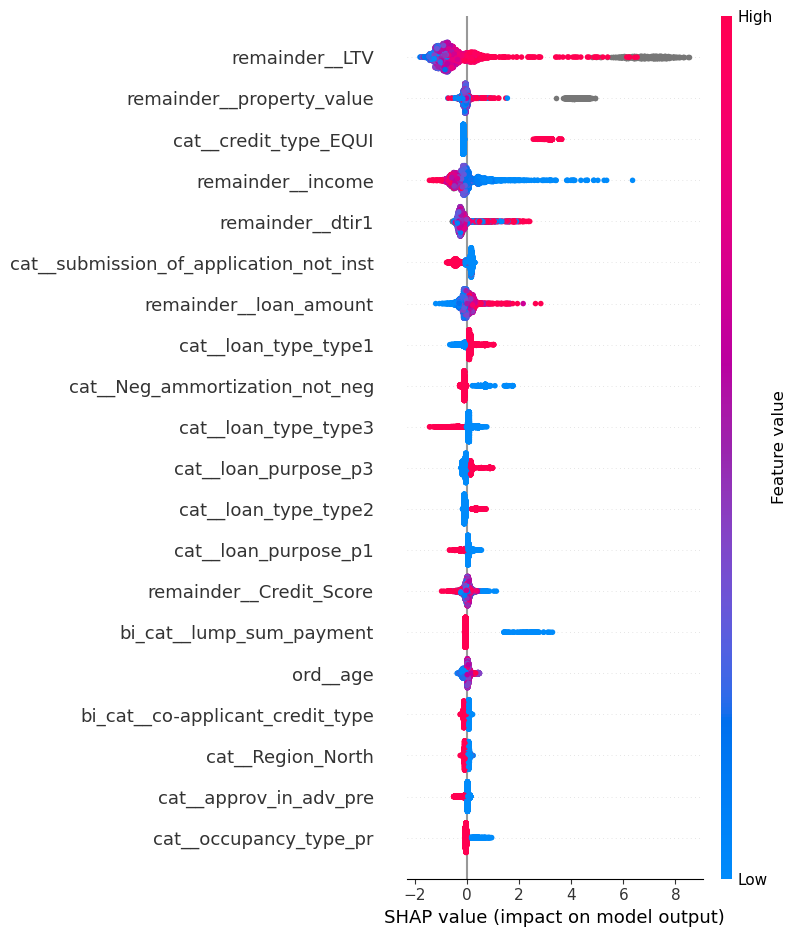

In [17]:
X_test_transformed = pd.DataFrame(X_test_transformed,columns=feature_names)
fig = plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_transformed, show=False)
fig.savefig('shap_summary_plot.png', bbox_inches='tight', dpi=500)

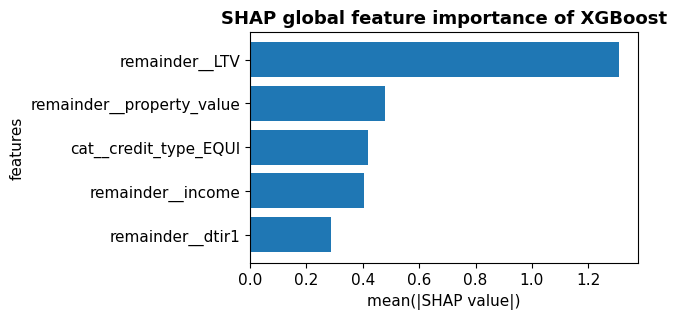

In [18]:
shap_summary = np.mean(np.abs(shap_values),axis=0) 
indcs = np.argsort(shap_summary)
shap_summary[indcs]

plt.figure(figsize=(5,3))
plt.barh(feature_names[indcs[-5:]],shap_summary[indcs[-5:]])
plt.xlabel('mean(|SHAP value|)')
plt.ylabel('features')
plt.title('SHAP global feature importance of XGBoost',fontsize=13, fontweight='bold')
plt.savefig('SHAP global feature importance of XGBoost.png', bbox_inches='tight', dpi=500)
plt.show()